About the Dataset:

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks whether the news article is real or fake:
           1: Fake news
           0: real News





This is a binary classification project so we will use a logistic regression model.


Importing the Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np #numpy arrays
import pandas as pd #dataframes
import matplotlib.pyplot as plt #data visulatization
import re #regular expression (useful for searching text in document)
from nltk.corpus import stopwords #don't add much value to our data - stopwords
from nltk.stem.porter import PorterStemmer #to perform stemming
#Stemming takes a word and removes the prefix and suffix of that word, giving only the root
from sklearn.feature_extraction.text import TfidfVectorizer #converting text into
#feature vectors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# printing the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**Data Pre-processing**

In [ ]:
# loading the dataset to a pandas DataFrame
news_dataset = pd.read_csv('/content/drive/MyDrive/DRDO project work/FakeNews Detection/train.csv')

In [ ]:
news_dataset.shape

(20800, 5)

In [ ]:
# print the first 5 rows of the dataframe
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
# counting the number of missing values in the dataset
news_dataset.isnull().sum()

,0
id,0
title,558
author,1957
text,39
label,0


In [ ]:
# replacing the null values with empty string
news_dataset = news_dataset.fillna('')

In [ ]:
news_dataset.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [ ]:
# merging the author name and news title
news_dataset['content'] = news_dataset['author']+' '+news_dataset['title']

In [ ]:
print(news_dataset['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [ ]:
# separating the data & label
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [ ]:
print(X)
print(Y)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

**Stemming:**

Stemming is the process of reducing a word to its Root word

example:
actor, actress, acting --> act

In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content) #removes everything which is not in a-z or A-Z (like ,) - data cleaning
    stemmed_content = stemmed_content.lower() #converting all alphabets to lower case letters
    stemmed_content = stemmed_content.split() #converting to list
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    #performing stemming on words which are not stopwords
    stemmed_content = ' '.join(stemmed_content) #joining all the words by spaces in between them (list to string)
    return stemmed_content

In [ ]:
news_dataset['content'] = news_dataset['content'].apply(stemming)

In [ ]:
print(news_dataset['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [ ]:
#separating the data and label
X = news_dataset['content'].values
Y = news_dataset['label'].values
#we are not using the text column of the initial dataset

In [ ]:
print(X)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv']


In [ ]:
print(Y)

[1 0 1 ... 0 1 1]


In [ ]:
Y.shape

(20800,)

In [ ]:
# Computer cannot understand text so that is why we are converting.
# Converting the textual data to numerical data
vectorizer = TfidfVectorizer() #counts the number of times a particular word is repeating
#in a document, it assigns a particular numerical value to that word. - term frequency
#idf - inverse document frequency, sometimes a word which is repeated several times
#does not have meaning in it. Suppose we are analyzing the reviews of a movie avengers
#so every review will contain the word avengers, but it is insignificant for our analyzing.
#So idf reduces this words importance value.
vectorizer.fit(X)
X = vectorizer.transform(X)

In [ ]:
print(X)

  (0, 267)	0.2701012497770876
  (0, 2483)	0.36765196867972083
  (0, 2959)	0.24684501285337127
  (0, 3600)	0.3598939188262558
  (0, 3792)	0.27053324808454915
  (0, 4973)	0.23331696690935097
  (0, 7005)	0.2187416908935914
  (0, 7692)	0.24785219520671598
  (0, 8630)	0.2921251408704368
  (0, 8909)	0.36359638063260746
  (0, 13473)	0.2565896679337956
  (0, 15686)	0.2848506356272864
  (1, 1497)	0.2939891562094648
  (1, 1894)	0.15521974226349364
  (1, 2223)	0.3827320386859759
  (1, 2813)	0.19094574062359204
  (1, 3568)	0.26373768806048464
  (1, 5503)	0.7143299355715573
  (1, 6816)	0.1904660198296849
  (1, 16799)	0.30071745655510157
  (2, 2943)	0.3179886800654691
  (2, 3103)	0.46097489583229645
  (2, 5389)	0.3866530551182615
  (2, 5968)	0.3474613386728292
  (2, 9620)	0.49351492943649944
  :	:
  (20797, 3643)	0.2115550061362374
  (20797, 7042)	0.21799048897828685
  (20797, 8364)	0.22322585870464115
  (20797, 8988)	0.36160868928090795
  (20797, 9518)	0.29542040034203126
  (20797, 9588)	0.17455348

Splitting the dataset to training & test data

In [ ]:
#test data should be 20%
#Startify ensures that there is equal proportion of seperation between real and fake news
#as was in the original dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

**Logistic Regression**

Training the Model: Logistic Regression

In [ ]:
model_lr = LogisticRegression()

In [ ]:
model_lr.fit(X_train, Y_train)

LogisticRegression()

Accuracy Score

In [ ]:
# accuracy score on the training data
X_train_prediction = model_lr.predict(X_train)
training_data_accuracy_lr = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of the training data : ', training_data_accuracy_lr)

Accuracy score of the training data :  0.9863581730769231


In [ ]:
# accuracy score on the test data
X_test_prediction = model_lr.predict(X_test)
test_data_accuracy_lr = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score of the test data : ', test_data_accuracy_lr)

Accuracy score of the test data :  0.9790865384615385


Confusion Matrix

In [ ]:
# calculate the confusion matrix
conf_mat = confusion_matrix(Y_test, X_test_prediction)

In [ ]:
# print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)

Confusion Matrix:
[[2004   73]
 [  14 2069]]


Classification Report

In [ ]:
# calculate the classification report
report = classification_report(Y_test, X_test_prediction)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2077
           1       0.97      0.99      0.98      2083

    accuracy                           0.98      4160
   macro avg       0.98      0.98      0.98      4160
weighted avg       0.98      0.98      0.98      4160



**Naive Bayes**

In [ ]:
model_nb = MultinomialNB()

In [ ]:
model_nb.fit(X_train, Y_train)

MultinomialNB()

Accuracy Score

In [ ]:
# accuracy score on the training data
X_train_prediction = model_nb.predict(X_train)
training_data_accuracy_nb = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of the training data : ', training_data_accuracy_nb)

Accuracy score of the training data :  0.9782451923076924


In [ ]:
# accuracy score on the test data
X_test_prediction = model_nb.predict(X_test)
test_data_accuracy_nb = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score of the test data : ', test_data_accuracy_nb)

Accuracy score of the test data :  0.9550480769230769


Confusion Matrix

In [ ]:
# calculate the confusion matrix
conf_mat = confusion_matrix(Y_test, X_test_prediction)

In [ ]:
# print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)

Confusion Matrix:
[[2064   13]
 [ 174 1909]]


Classification Report

In [ ]:
# calculate the classification report
report = classification_report(Y_test, X_test_prediction)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2077
           1       0.99      0.92      0.95      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.95      4160
weighted avg       0.96      0.96      0.95      4160



**Decision Tree**

In [ ]:
model_dt = DecisionTreeClassifier()

In [ ]:
model_dt.fit(X_train, Y_train)

DecisionTreeClassifier()

Accuracy Score

In [ ]:
# accuracy score on the training data
X_train_prediction = model_dt.predict(X_train)
training_data_accuracy_dt = accuracy_score(X_train_prediction, Y_train)

In [ ]:
print('Accuracy score of the training data : ', training_data_accuracy_dt)

Accuracy score of the training data :  1.0


In [ ]:
# accuracy score on the test data
X_test_prediction = model_dt.predict(X_test)
test_data_accuracy_dt = accuracy_score(X_test_prediction, Y_test)

In [ ]:
print('Accuracy score of the test data : ', test_data_accuracy_dt)

Accuracy score of the test data :  0.9925480769230769


Confusion Matrix

In [ ]:
# calculate the confusion matrix
conf_mat = confusion_matrix(Y_test, X_test_prediction)

In [ ]:
# print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)

Confusion Matrix:
[[2064   13]
 [  18 2065]]


Classification Report

In [ ]:
# calculate the classification report
report = classification_report(Y_test, X_test_prediction)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2077
           1       0.99      0.99      0.99      2083

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



**Conclusion**

In [ ]:
# create a list of model names and their corresponding accuracy scores
models = ['Logistic Regression', 'Naive Bayes', 'Decision Trees']
accuracy_scores = [test_data_accuracy_lr, test_data_accuracy_nb, test_data_accuracy_dt]

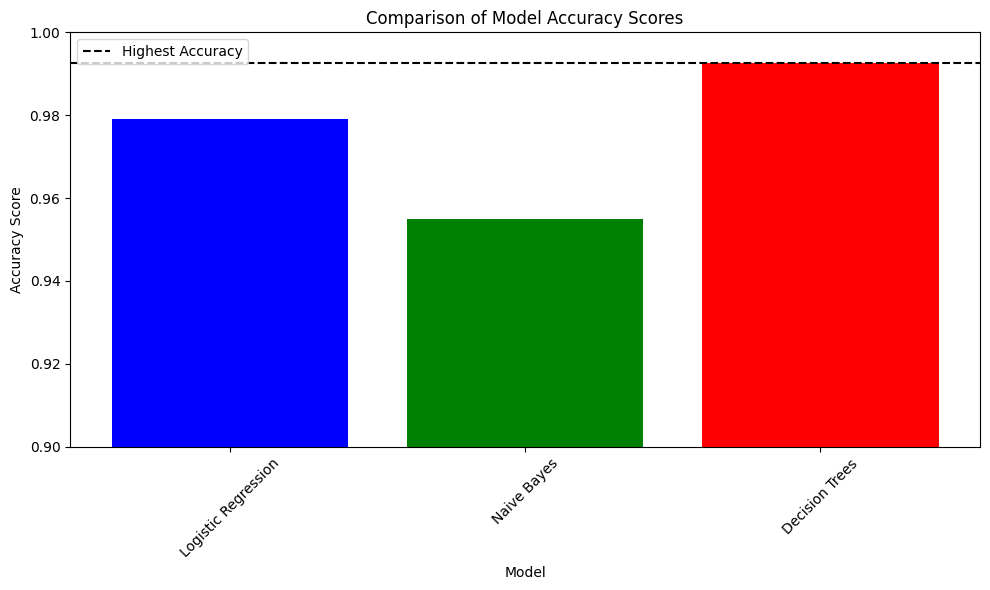

In [ ]:
# create a bar graph
plt.figure(figsize=(10, 6))  # increase figure size for better readability
plt.bar(models, accuracy_scores, color=['blue', 'green', 'red'])  # use different colors for each bar
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Comparison of Model Accuracy Scores')
plt.ylim(0.9, 1)  # set y-axis limit to 0.9-1 for better visualization
plt.xticks(rotation=45)  # rotate x-axis labels for better readability

# add a horizontal line to indicate the highest accuracy score
max_accuracy = max(accuracy_scores)
plt.axhline(y=max_accuracy, color='black', linestyle='--', label='Highest Accuracy')

# add a legend
plt.legend()

# show the plot
plt.tight_layout()
plt.show()

In [ ]:
#This bag graph shows us that the maximum accuracy is provided by Decision Trees Model.

Making a Predictive System

In [ ]:
X_new = X_test[3]

prediction = model_dt.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real


In [ ]:
print(Y_test[3])

0
